## Notebook Undownsampled

Related to ../Main_analysis.ipynb. This explores the possibility that the downsampling step distorts other metrics. Inspired by a unexpected duplication metric for the Quanta kit.

Consequently, a lot of the code is copied from Main_Analysis.

In [1]:
# This option controls whether the Swift long-insert libraries are included in the analysis.
# They are not a part of the main comparison.

INCLUDE_SWIFT_LONG_LIBS = True

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import re
import os
%matplotlib inline

def load_picard(path):
    with open(path) as f:
        mode = None
        metrics_header = None
        metrics_data = {}
        histogram_series = []
        histogram_data = []
        for l in f:
            line = l.rstrip("\r\n")
            if mode == 'metrics':
                metrics_header = line.split()
                mode = 'metrics2'
            elif mode == 'metrics2':
                if line != "":
                    metrics_data = dict(zip(metrics_header, line.split()))
                else:
                    mode = None
            elif mode == 'histogram':
                histogram_series = line.split()
                histogram_data = [list() for _ in histogram_series]
                mode = 'histogram2'
            elif mode == 'histogram2':
                if line != "":
                    for i, value in enumerate(line.split()):
                        histogram_data[i].append(value)
                else:
                    mode = None
            elif line.startswith("## METRICS CLASS"):
                mode = 'metrics'
            elif line.startswith("## HISTOGRAM"):
                mode = 'histogram'
        if histogram_series:
            #metrics_data['histograms'] = dict(zip(histogram_series, histogram_data))
            for name, data in zip(histogram_series, histogram_data):
                metrics_data[name] = [float(x) for x in data]
    return metrics_data

# Load the samples
samples = []
for bam in glob("../20_piccard/*.AlignmentSummaryMetrics.txt"):
    basepath = re.sub(r"\.AlignmentSummaryMetrics\.txt$", "", bam)
    data = {}
    try:
        for metrics in ['.AlignmentSummaryMetrics', '.InsertSizeMetrics',
                        '.MarkDuplicatesMetrics', '.WgsMetrics']:
            new_data = load_picard("{}{}.txt".format(basepath, metrics))
            if any(k in data for k in new_data):
                print("Duplicate key {} found in {}".format(k, metrics))
            data.update(new_data)
    except FileNotFoundError as e:
        print("File {} not found, skipping this sample.".format(e.filename))
        continue
    samples.append(data)

df = pd.DataFrame(samples).reindex().apply(pd.to_numeric, axis=0, errors='ignore')
df['Kit'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(0))
df['Conc'] = pd.Categorical(df.LIBRARY.str.split("-").str.get(1), categories=['10ng', '100ng'])
if not INCLUDE_SWIFT_LONG_LIBS:
    df = df.loc[df.Kit != "Swiftlong"]
    df.Kit = df.Kit.cat.set_categories(['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S'])
else:
    df.Kit = df.Kit.cat.set_categories(['Kapa', 'NEB', 'Nextera', 'Quanta', 'Swift2S', 'Swiftlong'])

print("Number of entries: ", len(df))

Number of entries:  48


# Utility function

In [3]:
def savefig(name, main=True):
    for fmt in ['png', 'pdf']:
        if main:
            if INCLUDE_SWIFT_LONG_LIBS:
                plt.savefig('../plots-main-withLong/{}.{}'.format(name, fmt))
            else:
                plt.savefig('../plots-main/{}.{}'.format(name, fmt))
        else:
            if INCLUDE_SWIFT_LONG_LIBS:
                plt.savefig('../plots-suppl-withLong/{}.{}'.format(name, fmt))
            else:
                plt.savefig('../plots-suppl/{}.{}'.format(name, fmt))

# Non-examp duplicates

(This gives expected values for the duplication, relative to the cluster in Main_analysis nb)

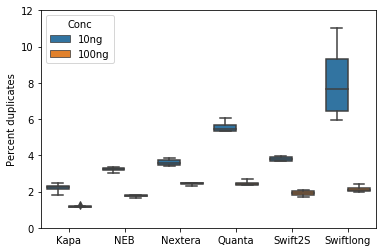

In [4]:
df['PERCENT_DUPLICATION_NON_OPTICAL'] = (
        (df.READ_PAIR_DUPLICATES - df.READ_PAIR_OPTICAL_DUPLICATES)*2 + df.UNPAIRED_READ_DUPLICATES
        ) * 100.0 / (
        df.READ_PAIRS_EXAMINED*2 + df.UNPAIRED_READS_EXAMINED
        )
sns.boxplot(data=df, x='Kit', y='PERCENT_DUPLICATION_NON_OPTICAL', hue='Conc')
#plt.title("Non-optical duplicates")
plt.ylabel("Percent duplicates")
plt.xlabel("")
if INCLUDE_SWIFT_LONG_LIBS:
    plt.ylim(0, 12)
else:
    plt.ylim(0, 7)
savefig('non-examp-duplicates')

# Overall library duplication

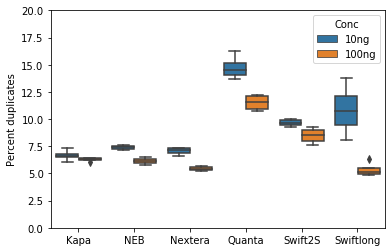

In [5]:
df['PERCENT_DUPLICATION_PERCENT'] = df.PERCENT_DUPLICATION * 100.0
sns.boxplot(data=df, x='Kit', y='PERCENT_DUPLICATION_PERCENT', hue='Conc')
#plt.title("Non-optical duplicates")
plt.ylabel("Percent duplicates")
plt.xlabel("")
plt.ylim(0, 20)
savefig('total-duplicates')

# Duplication in Quanta kit
Checking relative for pcr'd and pcr-free variants. It corresponds with expectations.

Quanta


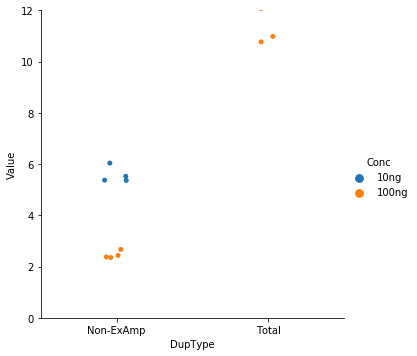

Swift2S


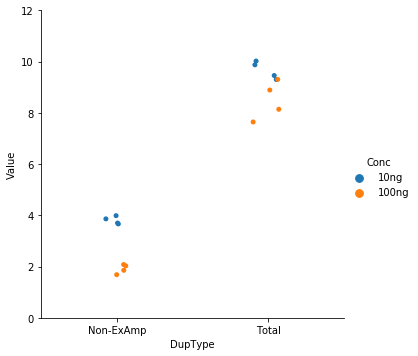

In [6]:
quanta = df[(df.Kit == 'Quanta')]
swift = df[(df.Kit == 'Swift2S')]
for kdf in [quanta, swift]:
    print(kdf.Kit.iloc[0])
    dfs = []
    for conc in ['10ng', '100ng']:
        quanta_dup = pd.DataFrame({'Value': kdf[kdf.Conc == conc]['PERCENT_DUPLICATION_NON_OPTICAL']})
        quanta_dup['DupType'] = 'Non-ExAmp'
        quanta_dup['Conc'] = conc
        dfs.append(quanta_dup)
        quanta_dup2 = pd.DataFrame({'Value': kdf[kdf.Conc == conc]['PERCENT_DUPLICATION']*100})
        quanta_dup2['DupType'] = 'Total'
        quanta_dup2['Conc'] = conc
        dfs.append(quanta_dup2)
    cat = pd.concat(dfs)
    sns.catplot(data=cat, x="DupType", y="Value", hue="Conc")
    plt.ylim(0, 12)
    plt.show()

    
